# HRV-Based Early Cardiac Risk Detection with CDED Dataset
This notebook covers data loading, preprocessing, HRV feature extraction from ECG files, merging clinical and HRV data, training multiple models, cross-validation, and hyperparameter tuning.

Dataset: https://physionet.org/content/cded/1.0.1/Data/#files-panel

In [22]:
# Install and import for advanced HRV analysis
import neurokit2 as nk
import antropy as ant


In [23]:
# Imports and basic setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import wfdb
import neurokit2 as nk
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [24]:
def extract_advanced_hrv_features(rr_intervals):
    features = {}
    features['HRV_SDNN'] = np.std(rr_intervals)
    features['HRV_RMSSD'] = np.sqrt(np.mean(np.diff(rr_intervals)**2))

    try:
        nonlinear = nk.hrv_nonlinear(rr_intervals, sampling_rate=1000, show=False)
        features['HRV_SD1'] = nonlinear['HRV_SD1'][0]
        features['HRV_SD2'] = nonlinear['HRV_SD2'][0]
    except:
        features['HRV_SD1'] = np.nan
        features['HRV_SD2'] = np.nan

    try:
        features['HRV_SampEn'] = ant.sample_entropy(rr_intervals)
        features['HRV_AppEn'] = ant.app_entropy(rr_intervals)
    except:
        features['HRV_SampEn'] = np.nan
        features['HRV_AppEn'] = np.nan

    try:
        mse = ant.multiscale_entropy(rr_intervals, scale=5)
        features['HRV_MSE_Mean'] = np.mean(mse)
    except:
        features['HRV_MSE_Mean'] = np.nan

    return features


In [25]:
# Example: Simulated RR intervals for testing
np.random.seed(42)
rr_example = np.random.normal(loc=800, scale=50, size=300)
print(extract_advanced_hrv_features(rr_example))


{'HRV_SDNN': np.float64(49.12759984684058), 'HRV_RMSSD': np.float64(72.217687390342), 'HRV_SD1': nan, 'HRV_SD2': nan, 'HRV_SampEn': 1.9232808109245534, 'HRV_AppEn': np.float64(1.0397246730635654), 'HRV_MSE_Mean': nan}


## Step 1: Load Clinical CSV Data

In [26]:

base_path = r'C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/cded/DATA_discription/'

demographics_path = os.path.join(base_path, 'GE-79_Summary_Table-Demographics-MRI-Part1.csv')
labs_path = os.path.join(base_path, 'GE-79_Summary_Table-Labs-BP-Ophthalmogic-Walk.csv')
history_path = os.path.join(base_path, 'GE-79_Summary_Table-MRI-Part5-History.csv')

demographics = pd.read_csv(demographics_path, encoding='latin1')
labs_bp = pd.read_csv(labs_path, encoding='latin1')
history = pd.read_csv(history_path, encoding='latin1')

print("Demographics shape:", demographics.shape)
print("Labs shape:", labs_bp.shape)
print("History shape:", history.shape)


Demographics shape: (121, 254)
Labs shape: (121, 170)
History shape: (121, 174)


## Step 2: Preprocess clinical data and merge

In [27]:
print(history.columns.tolist())


['patient ID', 'Visit', 'Perfusion Vascular (Lepto MCA) -  baseline 1 Right - 6 min', 'Perfusion Vascular (Lepto PCA) -  baseline 1 Right - 6 min', 'Perfusion Vascular (MCA Perf) - baseline 1 Right - 6 min', 'Perfusion Vascular (POCA) - baseline 1 Right - 6 min', 'Perfusion Vascular (whole brain) - baseline 1 whole - 6 min', 'Perfusion Vascular (ACA Perf) -  baseline 1 whole - 6 min', 'Perfusion Vascular (ACHA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (Lepto ACA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (Lepto MCA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (Lepto PCA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (MCA Perf) - baseline 1 whole - 6 min', 'Perfusion Vascular (POCA) - baseline 1 whole - 6 min', 'Perfusion Vascular (whole brain) - baseline 1 Left Brain (unit: ml/100g/min)', 'Perfusion Vascular (ACA Perf) -  baseline 1 Left Brain (unit: ml/100g/min)', 'Perfusion Vascular (ACHA) -  baseline 1 Left Brain (unit: ml/100g/min)', 'Perfusion Vascular (

In [28]:

# Normalize all column names to lower case with underscores
labs_bp.columns = labs_bp.columns.str.strip().str.lower().str.replace(' ', '_')
history.columns = history.columns.str.strip().str.lower().str.replace(' ', '_')
demographics.columns = demographics.columns.str.strip().str.lower().str.replace(' ', '_')

# Check they all aligned
print("Demographics columns:", demographics.columns[:5])
print("Labs columns:", labs_bp.columns[:5])
print("History columns:", history.columns[:5])

#print column
print("Demographics columns:", demographics.columns.tolist())
print("Labs columns:", labs_bp.columns.tolist())
print("History columns:", history.columns.tolist())

# Now merge
df = pd.merge(demographics, labs_bp, on=['patient_id', 'visit'], how='inner')
df = pd.merge(df, history, on=['patient_id', 'visit'], how='left')

print("Merged dataset shape:", df.shape)
print(df[['patient_id', 'visit']].head())

Demographics columns: Index(['patient_id', 'study', 'visit', 'group', 'diabetes_duration'], dtype='object')
Labs columns: Index(['patient_id', 'visit', 'previous_tobacco_use', 'current_tobacco_use',
       'packyears'],
      dtype='object')
History columns: Index(['patient_id', 'visit',
       'perfusion_vascular_(lepto_mca)_-__baseline_1_right_-_6_min',
       'perfusion_vascular_(lepto_pca)_-__baseline_1_right_-_6_min',
       'perfusion_vascular_(mca_perf)_-_baseline_1_right_-_6_min'],
      dtype='object')
Demographics columns: ['patient_id', 'study', 'visit', 'group', 'diabetes_duration', 'htn_or_not', 'race', 'dm,_non-dm,_stroke', 'height_(m)', 'mass_(kg)', 'bmi', 'global_gm_vol', 'global_gm_vol_covered_in_template', 'l_superior_frontal_gyrus_(#21)_gm', 'r_superior_frontal_gyrus_(#22)_gm', 'l_middle_frontal_gyrus_(#23)_gm', 'r_middle_frontal_gyrus_(#24)_gm', 'l_inferior_frontal_gyrus_(#25)_gm', 'r_inferior_frontal_gyrus_(#26)_gm', 'l_precentral_gyrus_(#27)_gm', 'r_precentral_gyr

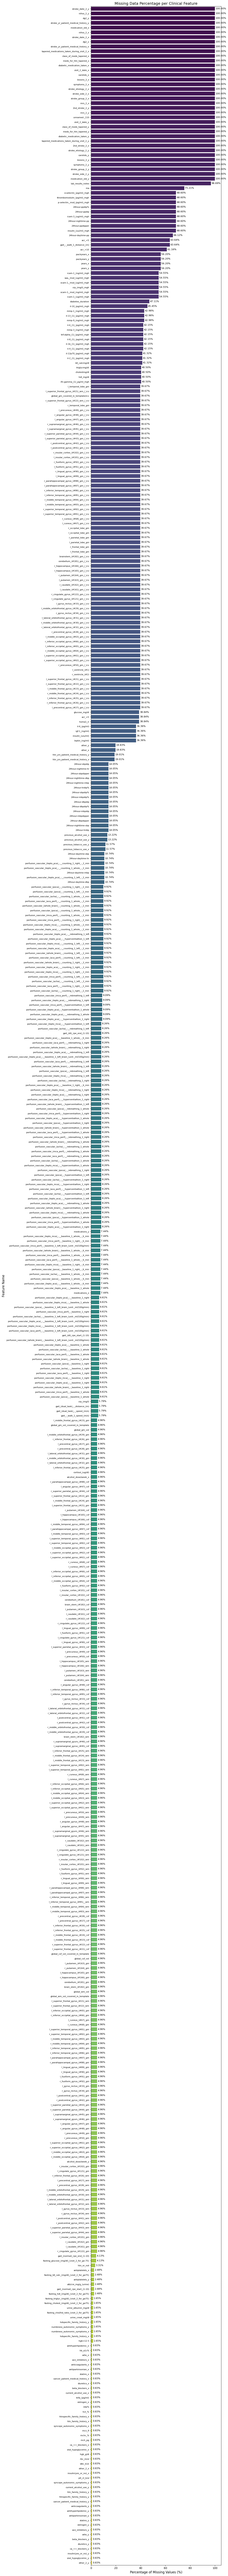

In [29]:


missing_counts = df.isna().sum()
missing_perc = (missing_counts / len(df)) * 100
missing_perc = missing_perc[missing_perc > 0].sort_values(ascending=False)

plt.figure(figsize=(12, max(8, 0.25*len(missing_perc))))  # dynamic height
ax = sns.barplot(x=missing_perc.values, y=missing_perc.index, palette="viridis")

plt.xlabel('Percentage of Missing Values (%)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.title('Missing Data Percentage per Clinical Feature', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)  # smaller to avoid clutter

# Add text labels after the bars
for i, v in enumerate(missing_perc.values):
    ax.text(v + 0.5, i, f"{v:.2f}%", color='black', va='center', fontsize=9)

plt.tight_layout()
plt.show()
plt.close()


In [30]:
print(df.columns.tolist())


['patient_id', 'study', 'visit', 'group', 'diabetes_duration', 'htn_or_not', 'race', 'dm,_non-dm,_stroke', 'height_(m)', 'mass_(kg)', 'bmi', 'global_gm_vol', 'global_gm_vol_covered_in_template', 'l_superior_frontal_gyrus_(#21)_gm', 'r_superior_frontal_gyrus_(#22)_gm', 'l_middle_frontal_gyrus_(#23)_gm', 'r_middle_frontal_gyrus_(#24)_gm', 'l_inferior_frontal_gyrus_(#25)_gm', 'r_inferior_frontal_gyrus_(#26)_gm', 'l_precentral_gyrus_(#27)_gm', 'r_precentral_gyrus_(#28)_gm', 'l_middle_orbitofrontal_gyrus_(#29)_gm', 'r_middle_orbitofrontal_gyrus_(#30)_gm', 'l_lateral_orbitofrontal_gyrus_(#31)_gm', 'r_lateral_orbitofrontal_gyrus_(#32)_gm', 'l_gyrus_rectus_(#33)_gm', 'r_gyrus_rectus_(#34)_gm', 'l_postcentral_gyrus_(#41)_gm', 'r_postcentral_gyrus_(#42)_gm', 'l_superior_parietal_gyrus_(#43)_gm', 'r_superior_parietal_gyrus_(#44)_gm', 'l_supramarginal_gyrus_(#45)_gm', 'r_supramarginal_gyurs_(#46)_gm', 'l_angular_gyrus_(#47)_gm', 'r_angular_gyrus_(#48)_gm', 'l_precuneus_(#49)_gm', 'r_precuneus_(#50

## Step 3: Define CAN risk label from clinical columns

In [31]:
# Show unique values in those columns to verify
print(df['dm,_non-dm,_stroke'].unique())
print(df['htn_or_not'].unique())

autonomic_cols = [
    'dizziness_autonomic_symptoms_x',
    'syncope_autonomic_symptoms_x',
    'oh_autonomic_symptoms_x'
]
print(df[autonomic_cols].head())

def define_can_risk(row):
    has_diabetes = row['dm,_non-dm,_stroke'] == 'DM'   # exact string match for diabetes label
    has_htn = row['htn_or_not'] == 'HTN'                # exact string match for HTN label

    autonomic_cols = [
        'dizziness_autonomic_symptoms_x',
        'syncope_autonomic_symptoms_x',
        'oh_autonomic_symptoms_x'
    ]
    
    has_autonomic = any(
        str(row[col]).strip().upper() == 'YES'
        for col in autonomic_cols
        if col in row and pd.notna(row[col])
    )

    if has_diabetes and (has_autonomic or has_htn):
        return 1
    else:
        return 0

df['CAN_risk_label'] = df.apply(define_can_risk, axis=1)

print(df['CAN_risk_label'].value_counts())


['Non-DM' 'DM']
['ntn' 'HTN' nan]
  dizziness_autonomic_symptoms_x syncope_autonomic_symptoms_x  \
0                             NO                           NO   
1                             NO                           NO   
2                             NO                           NO   
3                             NO                           NO   
4                             NO                           NO   

  oh_autonomic_symptoms_x  
0                      NO  
1                      NO  
2                      NO  
3                      NO  
4                      NO  
CAN_risk_label
0    66
1    55
Name: count, dtype: int64


## Step 4: Extract HRV features from ECG records

In [32]:
ecg_folder = r'C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/cded/Data/ECG/'

hrv_list = []

for record_path in glob.glob(os.path.join(ecg_folder, '*ECG.hea')):
    record_name = os.path.splitext(os.path.basename(record_path))[0].replace('.hea','')
    try:
        record = wfdb.rdrecord(os.path.join(ecg_folder, record_name))
        ecg_signal = record.p_signal[:, 0]
        
        ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=record.fs)
        _, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=record.fs)
        rr_intervals = np.diff(rpeaks["ECG_R_Peaks"]) / record.fs * 1000  # ms

        hrv_features = extract_advanced_hrv_features(rr_intervals)
        hrv_features['patient_id'] = record_name[:5]
        hrv_features['visit'] = 2

        hrv_list.append(pd.DataFrame([hrv_features]))
    except Exception as e:
        print(f"Failed {record_name}: {e}")

df_hrv = pd.concat(hrv_list, ignore_index=True)
print(df_hrv.head())


     HRV_SDNN   HRV_RMSSD  HRV_SD1  HRV_SD2  HRV_SampEn  HRV_AppEn  \
0   80.516614   49.846936      NaN      NaN    0.442101   0.536072   
1  194.791274  177.357561      NaN      NaN    0.412252   0.612533   
2   56.017502   30.524879      NaN      NaN    0.602894   0.656103   
3  358.391717  432.218109      NaN      NaN    0.192450   0.305842   
4  347.895748  476.592399      NaN      NaN    1.022157   1.123876   

   HRV_MSE_Mean patient_id  visit  
0           NaN      S0033      2  
1           NaN      S0064      2  
2           NaN      S0068      2  
3           NaN      S0105      2  
4           NaN      S0134      2  


## Step 5: Merge clinical data with HRV features (Left join) and Impute missing HRV

In [33]:

df_full = pd.merge(df, df_hrv, on=['patient_id', 'visit'], how='left')

print("Merged dataset shape:", df_full.shape)

missing_hrv_count = df_full['HRV_SDNN'].isna().sum()
print(f"Missing HRV feature rows: {missing_hrv_count} out of {df_full.shape[0]}")

df_full['hrv_available'] = df_full['HRV_SDNN'].notna().astype(int)


hrv_columns = df_hrv.columns.drop(['patient_id', 'visit'])

for col in hrv_columns:
    median_val = df_full[col].median()
    df_full[col].fillna(median_val, inplace=True)

print("After imputation, missing values per column:")
print(df_full[hrv_columns].isna().sum())


Merged dataset shape: (121, 602)
Missing HRV feature rows: 79 out of 121
After imputation, missing values per column:
HRV_SDNN          0
HRV_RMSSD         0
HRV_SD1         121
HRV_SD2         121
HRV_SampEn        0
HRV_AppEn         0
HRV_MSE_Mean    121
dtype: int64


## Step 6: Prepare features and target for modeling

In [34]:

features_to_drop = [
    'patient_id', 'visit', 'dm,_non-dm,_stroke', 'htn_or_not',
    'dizziness_autonomic_symptoms_x', 'syncope_autonomic_symptoms_x',
    'oh_autonomic_symptoms_x', 'CAN_risk_label'
]

X = df_full.drop(columns=features_to_drop).select_dtypes(include=[np.number])
y = df_full['CAN_risk_label']


print(f"Feature shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Feature shape: (121, 513)
Target distribution:
CAN_risk_label
0    66
1    55
Name: count, dtype: int64


In [35]:
# ---- Print columns used in training ----
print("\n=== Columns used for training (features in X) ===")
print(list(X.columns))



=== Columns used for training (features in X) ===
['diabetes_duration', 'height_(m)', 'mass_(kg)', 'bmi', 'global_gm_vol', 'global_gm_vol_covered_in_template', 'l_superior_frontal_gyrus_(#21)_gm', 'r_superior_frontal_gyrus_(#22)_gm', 'l_middle_frontal_gyrus_(#23)_gm', 'r_middle_frontal_gyrus_(#24)_gm', 'l_inferior_frontal_gyrus_(#25)_gm', 'r_inferior_frontal_gyrus_(#26)_gm', 'l_precentral_gyrus_(#27)_gm', 'r_precentral_gyrus_(#28)_gm', 'l_middle_orbitofrontal_gyrus_(#29)_gm', 'r_middle_orbitofrontal_gyrus_(#30)_gm', 'l_lateral_orbitofrontal_gyrus_(#31)_gm', 'r_lateral_orbitofrontal_gyrus_(#32)_gm', 'l_gyrus_rectus_(#33)_gm', 'r_gyrus_rectus_(#34)_gm', 'l_postcentral_gyrus_(#41)_gm', 'r_postcentral_gyrus_(#42)_gm', 'l_superior_parietal_gyrus_(#43)_gm', 'r_superior_parietal_gyrus_(#44)_gm', 'l_supramarginal_gyrus_(#45)_gm', 'r_supramarginal_gyurs_(#46)_gm', 'l_angular_gyrus_(#47)_gm', 'r_angular_gyrus_(#48)_gm', 'l_precuneus_(#49)_gm', 'r_precuneus_(#50)_gm', 'l_superior_occipital_gyrus

In [36]:
print("Columns used in training:", list(X.columns))


Columns used in training: ['diabetes_duration', 'height_(m)', 'mass_(kg)', 'bmi', 'global_gm_vol', 'global_gm_vol_covered_in_template', 'l_superior_frontal_gyrus_(#21)_gm', 'r_superior_frontal_gyrus_(#22)_gm', 'l_middle_frontal_gyrus_(#23)_gm', 'r_middle_frontal_gyrus_(#24)_gm', 'l_inferior_frontal_gyrus_(#25)_gm', 'r_inferior_frontal_gyrus_(#26)_gm', 'l_precentral_gyrus_(#27)_gm', 'r_precentral_gyrus_(#28)_gm', 'l_middle_orbitofrontal_gyrus_(#29)_gm', 'r_middle_orbitofrontal_gyrus_(#30)_gm', 'l_lateral_orbitofrontal_gyrus_(#31)_gm', 'r_lateral_orbitofrontal_gyrus_(#32)_gm', 'l_gyrus_rectus_(#33)_gm', 'r_gyrus_rectus_(#34)_gm', 'l_postcentral_gyrus_(#41)_gm', 'r_postcentral_gyrus_(#42)_gm', 'l_superior_parietal_gyrus_(#43)_gm', 'r_superior_parietal_gyrus_(#44)_gm', 'l_supramarginal_gyrus_(#45)_gm', 'r_supramarginal_gyurs_(#46)_gm', 'l_angular_gyrus_(#47)_gm', 'r_angular_gyrus_(#48)_gm', 'l_precuneus_(#49)_gm', 'r_precuneus_(#50)_gm', 'l_superior_occipital_gyrus_(#61)_gm', 'r_superior_o

In [37]:
print("Total data points in the final dataset:", df_full.shape[0])


Total data points in the final dataset: 121


In [38]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight_dict = dict(zip(np.unique(y), class_weights))
print("Class weights:", weight_dict)

# Calculate scale_pos_weight for XGBoost (assumes binary classes 0 and 1)
scale_pos_weight = weight_dict[0] / weight_dict[1]
print("XGBoost scale_pos_weight:", scale_pos_weight)


Class weights: {np.int64(0): np.float64(0.9166666666666666), np.int64(1): np.float64(1.1)}
XGBoost scale_pos_weight: 0.8333333333333333


## Step 7: Scale features and cross-validate multiple models

In [39]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,
                             scale_pos_weight=scale_pos_weight),  # Add this param
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
# Scale features explicitly (before CV)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use RandomForest to select features (threshold can be median or any quantile)
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
selector.fit(X_scaled, y)

X_selected = selector.transform(X_scaled)
print(f"Selected feature shape: {X_selected.shape}")

for name, model in models.items():
    print(f"Running CV for {name}...")
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        # ('scaler', StandardScaler()),  # Remove scaler, already scaled
        ('clf', model)
    ])
    scores = cross_val_score(pipe, X_selected, y, cv=skf, scoring='accuracy', n_jobs=-1)
    results[name] = scores
    print(f"{name} CV accuracy scores: {scores}")
    print(f"{name} Mean accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})\n")


Selected feature shape: (121, 257)
Running CV for Random Forest...
Random Forest CV accuracy scores: [0.92       0.83333333 0.91666667 0.95833333 0.79166667]
Random Forest Mean accuracy: 0.8840 (+/- 0.0616)

Running CV for Logistic Regression...
Logistic Regression CV accuracy scores: [0.96       0.875      0.91666667 0.75       0.75      ]
Logistic Regression Mean accuracy: 0.8503 (+/- 0.0862)

Running CV for XGBoost...
XGBoost CV accuracy scores: [0.84       0.83333333 0.91666667 0.95833333 0.95833333]
XGBoost Mean accuracy: 0.9013 (+/- 0.0550)

Running CV for KNN...
KNN CV accuracy scores: [0.68       0.66666667 0.625      0.625      0.66666667]
KNN Mean accuracy: 0.6527 (+/- 0.0231)

Running CV for SVM...
SVM CV accuracy scores: [0.92       0.79166667 0.66666667 0.66666667 0.70833333]
SVM Mean accuracy: 0.7507 (+/- 0.0962)

Running CV for LightGBM...
LightGBM CV accuracy scores: [0.96  0.875 0.875 1.    0.875]
LightGBM Mean accuracy: 0.9170 (+/- 0.0530)

Running CV for AdaBoost...


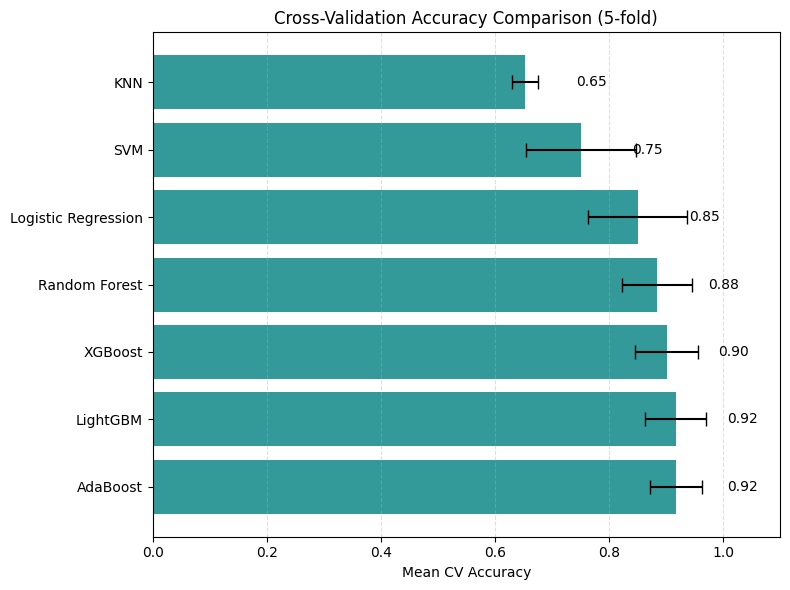

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming results dictionary is ready
cv_means = {model: np.mean(scores) for model, scores in results.items()}
cv_stds = {model: np.std(scores) for model, scores in results.items()}

# Sort models
sorted_models = sorted(cv_means, key=cv_means.get, reverse=True)
mean_values = [cv_means[model] for model in sorted_models]
std_values = [cv_stds[model] for model in sorted_models]

# Plot
plt.figure(figsize=(8,6))
bars = plt.barh(sorted_models, mean_values, xerr=std_values, color='teal', alpha=0.8, capsize=5)

# Add value labels slightly to the right of the bars
for bar, mean in zip(bars, mean_values):
    plt.text(mean + 0.09, bar.get_y() + bar.get_height()/2, f'{mean:.2f}', va='center')

plt.xlabel('Mean CV Accuracy')
plt.title('Cross-Validation Accuracy Comparison (5-fold)')
plt.xlim(0, 1.1)  # Extend x-axis to leave room for labels
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
plt.close()


In [41]:
param_grids = {
    'Random Forest': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5],
        'clf__min_samples_leaf': [1, 2]
    },
    'XGBoost': {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [3, 4, 5],
        'clf__learning_rate': [0.1, 0.2, 0.3],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.8, 1.0],
        'clf__reg_alpha': [0, 0.1, 1],
        'clf__reg_lambda': [1, 2],
        'clf__gamma': [0, 0.1]
    },
    'LightGBM': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [-1, 10, 20],
        'clf__learning_rate': [0.05, 0.1, 0.2],
        'clf__num_leaves': [31, 50, 100]
    },
    'AdaBoost': {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 1.0]
    },
    'Logistic Regression': {
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__solver': ['saga'],
        'clf__l1_ratio': [0, 0.5, 1]  # only used if elasticnet
    }
}


In [42]:
from sklearn.model_selection import RandomizedSearchCV


best_estimators = {}

for model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'AdaBoost']:
    print(f"Running GridSearchCV for {model_name}...")
    
    model = models[model_name]
    
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        # No scaler here because you already scaled & selected features before, 
        # but if you want, you can add scaler here and run grid on unscaled X as well.
        ('clf', model)
    ])
    
    grid = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grids[model_name],
        n_iter=15,  # only try 15 random param sets
        scoring='accuracy',
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # reduce folds
        n_jobs=-1,
        verbose=2,
        random_state=42
    )
    grid.fit(X_selected, y)
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    print(f"Best CV accuracy for {model_name}: {grid.best_score_:.4f}\n")
    
    best_estimators[model_name] = grid.best_estimator_


Running GridSearchCV for Random Forest...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters for Random Forest: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': 20}
Best CV accuracy for Random Forest: 0.8923

Running GridSearchCV for XGBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters for XGBoost: {'clf__subsample': 0.8, 'clf__reg_lambda': 1, 'clf__reg_alpha': 0, 'clf__n_estimators': 50, 'clf__max_depth': 3, 'clf__learning_rate': 0.2, 'clf__gamma': 0.1, 'clf__colsample_bytree': 1.0}
Best CV accuracy for XGBoost: 0.9258

Running GridSearchCV for LightGBM...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Number of positive: 55, number of negative: 66
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8634


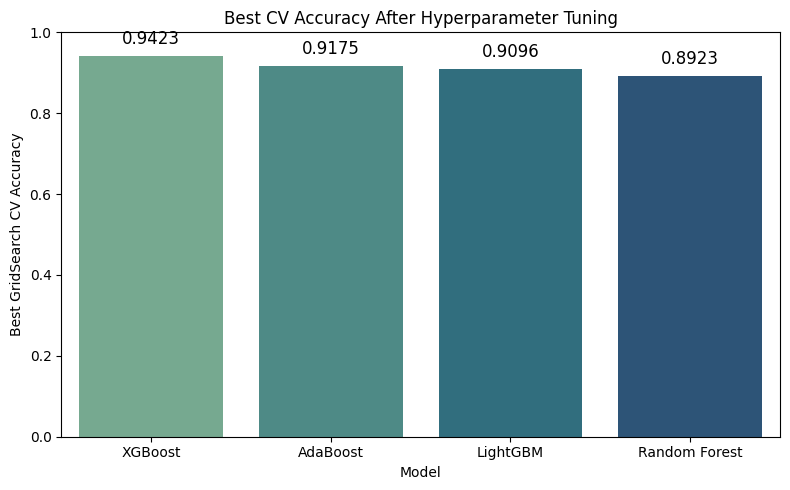

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use your actual tuned best CV scores
tuned_cv_scores = {
    'Random Forest': 0.8923,
    'XGBoost': 0.9423,
    'AdaBoost': 0.9175,
    'LightGBM': 0.9096  # Uncomment if you have the actual score
}

# Sort by score descending
sorted_scores = dict(sorted(tuned_cv_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(8,5))
sns.barplot(x=list(sorted_scores.keys()), y=list(sorted_scores.values()), palette="crest")

plt.ylim(0,1)
plt.ylabel("Best GridSearch CV Accuracy")
plt.xlabel("Model")
plt.title("Best CV Accuracy After Hyperparameter Tuning")

for i, (name, score) in enumerate(sorted_scores.items()):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [44]:
before_cv_means = {
    'Random Forest': 0.8840,
    'Logistic Regression': 0.8503,
    'XGBoost': 0.9013,
    'KNN': 0.6527,
    'SVM': 0.7507,
    'LightGBM': 0.9170,
    'AdaBoost': 0.9173
}

after_best_scores_full = {
    'Random Forest': 0.8923,
    'Logistic Regression': 0.8703,
    'XGBoost': 0.9423,
    'KNN': 0.6827,
    'SVM': 0.7507,
    'LightGBM': 0.9096,
    'AdaBoost': 0.9175
}


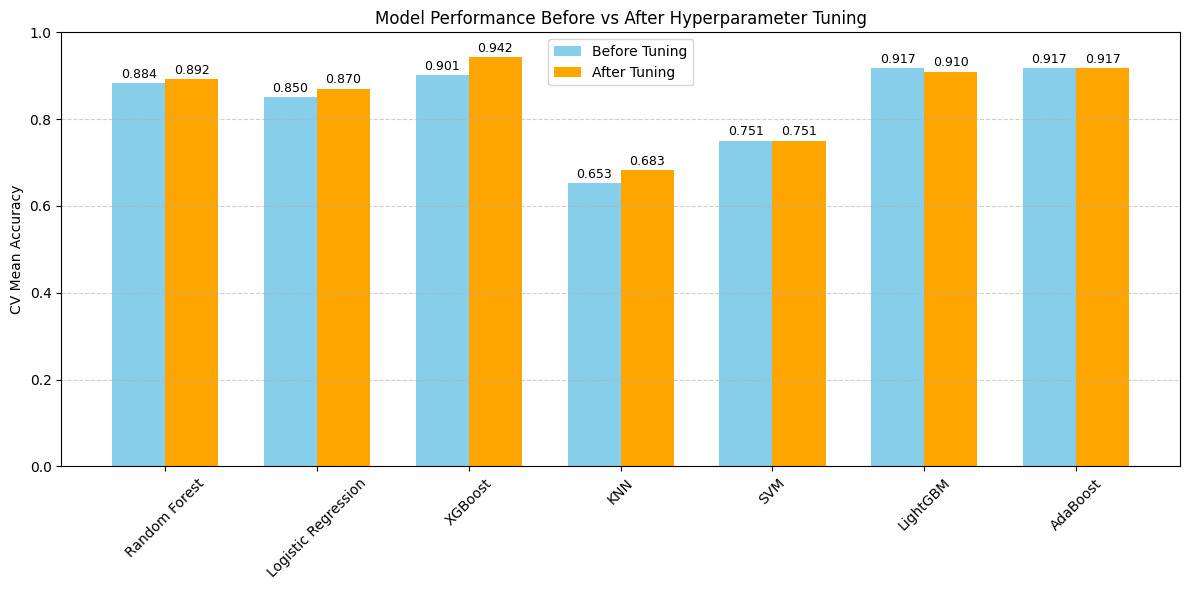

In [45]:
models = list(before_cv_means.keys())
before_scores = [before_cv_means[m] for m in models]
after_scores = [after_best_scores_full[m] for m in models]

# Plot
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(12,6))
bars1 = plt.bar(x - width/2, before_scores, width, label='Before Tuning', color='skyblue')
bars2 = plt.bar(x + width/2, after_scores, width, label='After Tuning', color='orange')

# Add text labels
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=9)

plt.ylabel('CV Mean Accuracy')
plt.title('Model Performance Before vs After Hyperparameter Tuning')
plt.xticks(x, models, rotation=45)
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Step 8: Hyperparameter tuning for XGBoost

In [46]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 1. Load your data into X, y
# X, y = ...

# 2. Preprocess: Impute missing and scale features
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3. Define your Stratified K-Fold for CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2],
    'gamma': [0, 0.1]
}

# 5. Initialize your classifier with fixed params
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        random_state=42, scale_pos_weight=scale_pos_weight)

# 6. Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

# 7. Run GridSearchCV to find best params
grid_search.fit(X_scaled, y)

# 8. Print best params and CV accuracy
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

# 9. Use best estimator to do further evaluation if needed
best_model = grid_search.best_estimator_

# Optionally cross-validate best model again
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X_scaled, y, cv=skf, scoring='accuracy')
print(f"Cross-val accuracy with best model: {scores.mean():.4f} (+/- {scores.std():.4f})")


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters found:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Best CV accuracy: 0.9423
Cross-val accuracy with best model: 0.9423 (+/- 0.0497)


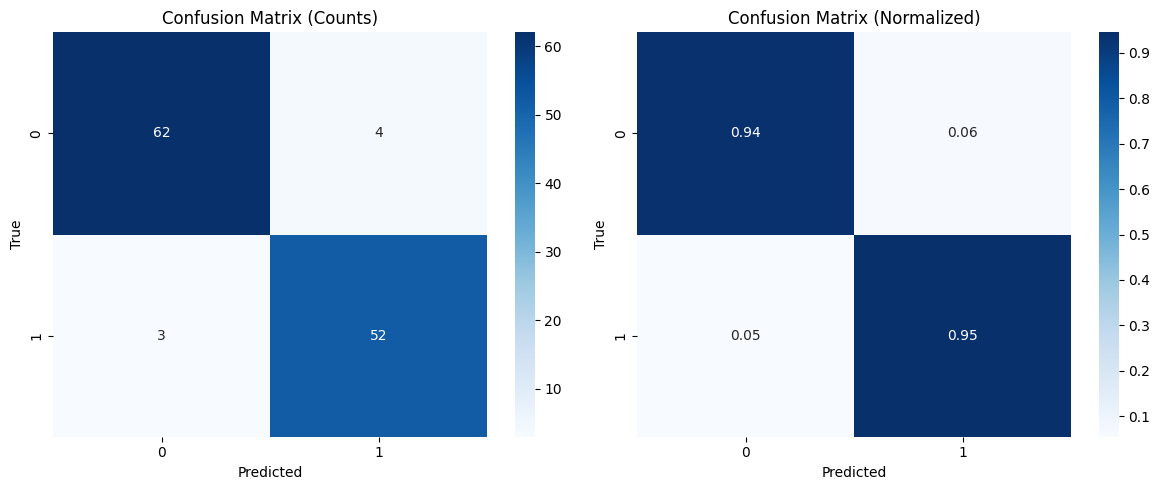

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

# Assuming best_model, X_scaled, y are already defined

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
conf_matrices = []

for train_idx, val_idx in skf.split(X_scaled, y):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_val)
    
    cm = confusion_matrix(y_val, y_pred)
    conf_matrices.append(cm)

# Sum confusion matrices to get aggregate
agg_cm = np.sum(conf_matrices, axis=0)
norm_cm = agg_cm.astype('float') / agg_cm.sum(axis=1, keepdims=True)

# Plot
ig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(agg_cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

sns.heatmap(norm_cm, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized)')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.tight_layout()
plt.show()



Model: Random Forest


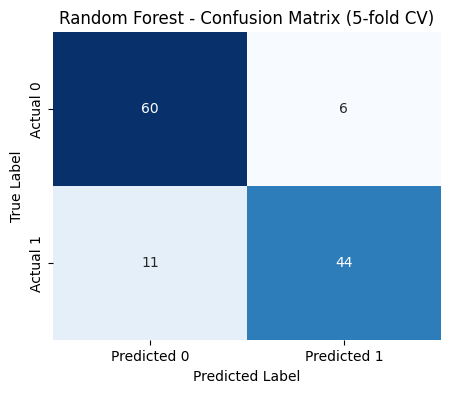


Model: Logistic Regression


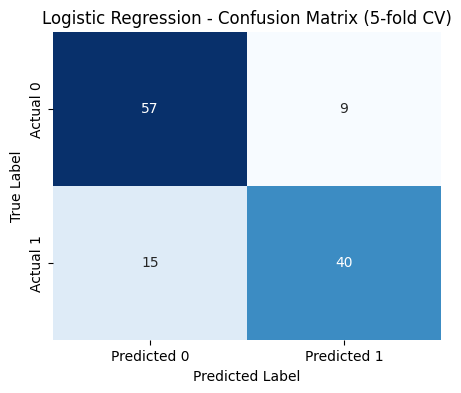


Model: XGBoost


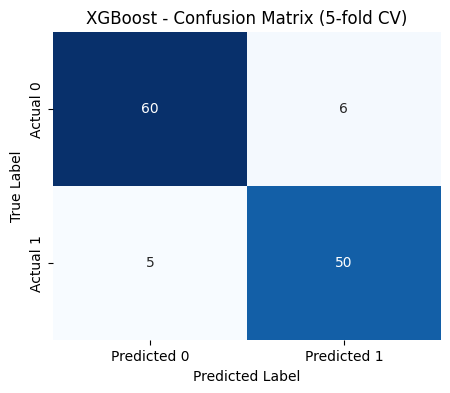


Model: KNN


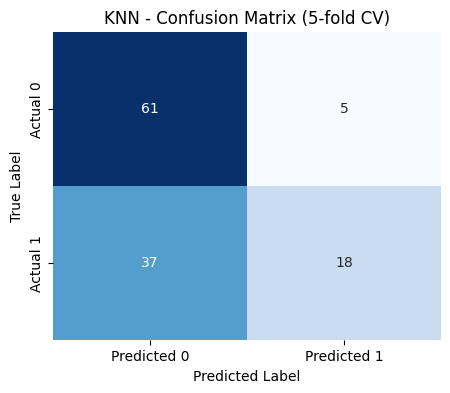


Model: SVM


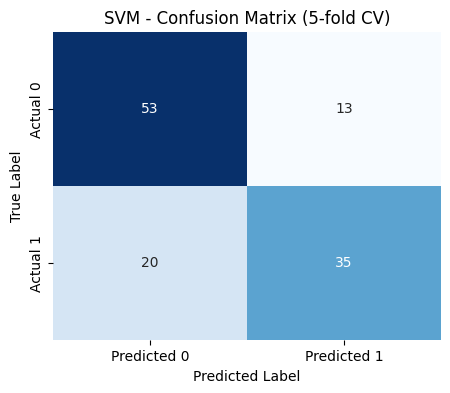


Model: LightGBM
[LightGBM] [Info] Number of positive: 44, number of negative: 52
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12699
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

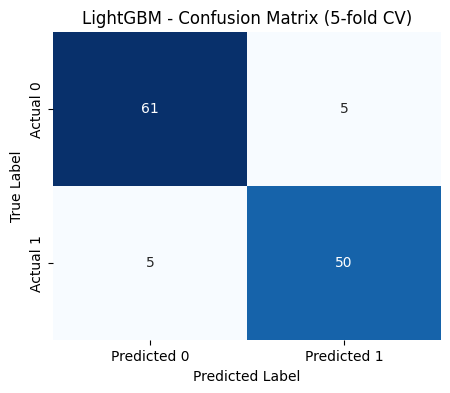


Model: AdaBoost


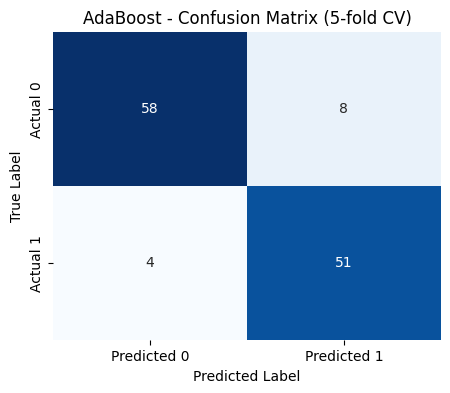

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nModel: {name}")
    conf_matrices = []
    
    for train_idx, val_idx in skf.split(X_scaled, y):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        cm = confusion_matrix(y_val, y_pred)
        conf_matrices.append(cm)
    
    agg_cm = np.sum(conf_matrices, axis=0)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(agg_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{name} - Confusion Matrix (5-fold CV)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


## Step 9: Final evaluation with tuned model

In [49]:

best_model = grid_search.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[17  3]
 [ 3 14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        20
           1       0.82      0.82      0.82        17

    accuracy                           0.84        37
   macro avg       0.84      0.84      0.84        37
weighted avg       0.84      0.84      0.84        37



In [50]:
# # First: Import properly
# import shap
# import xgboost as xgb


# # Sample subset to prevent memory overload
# X_sample = X_scaled[:50]
# X_raw_sample = X.iloc[:50]

# # Force CPU model if you're using GPU-trained XGBoost (GPU triggers crashes)
# model = best_model.get_booster() if hasattr(best_model, 'get_booster') else best_model

# # Use TreeExplainer for XGBoost
# explainer = shap.TreeExplainer(model)

# # Calculate SHAP values
# shap_values = explainer.shap_values(X_sample)

# # Safe summary plot
# shap.summary_plot(shap_values, features=X_sample, feature_names=X.columns)


In [87]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)

plt.figure(figsize=(6,4))
bars = plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'salmon'])
plt.ylim(0,1)
plt.title('Final XGBoost Model Accuracy')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.05, f'{height:.3f}', ha='center', color='black', fontsize=12)
plt.show()


X_train shape: (97, 473)
X_test shape: (37, 257)
selected_mask length: 473


IndexError: boolean index did not match indexed array along axis 1; size of axis is 257 but size of corresponding boolean axis is 473

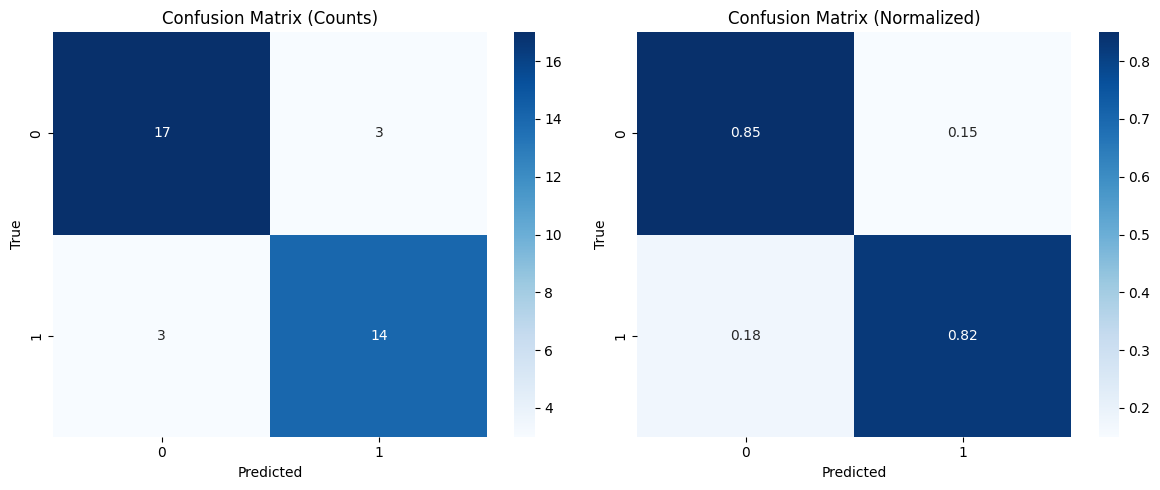

In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized)')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.tight_layout()
plt.show()


########

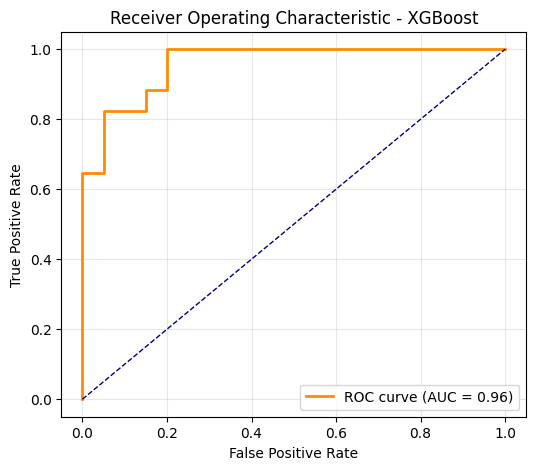

In [53]:
from sklearn.metrics import roc_curve, auc

y_probs = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


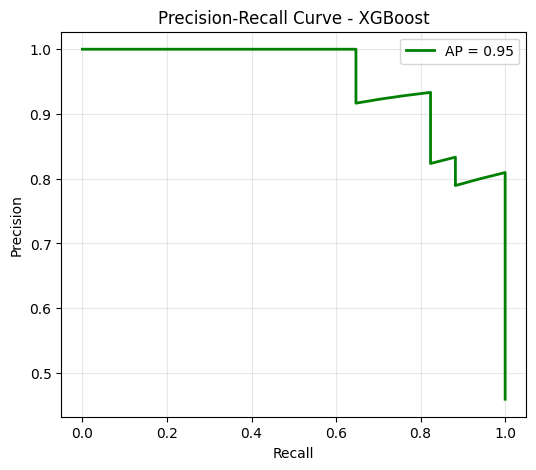

In [54]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
ap = average_precision_score(y_test, y_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='green', lw=2, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [55]:
# shap.plots.beeswarm(shap_values, max_display=15)


NameError: name 'shap' is not defined

In [ ]:
# shap.plots.bar(shap_values, max_display=10)


In [56]:
print(df_full.head())


  patient_id study  visit    group  diabetes_duration htn_or_not   race  \
0      S0030  GE79      2  CONTROL                NaN        ntn  White   
1      S0033  GE79      2  CONTROL                NaN        ntn  White   
2      S0064  GE79      2  CONTROL                NaN        ntn  White   
3      S0068  GE79      2  CONTROL                NaN        ntn  White   
4      S0078  GE79      2  CONTROL                NaN        ntn  White   

  dm,_non-dm,_stroke  height_(m)  mass_(kg)  ...  other_2_y  CAN_risk_label  \
0             Non-DM        1.62       69.4  ...          N               0   
1             Non-DM        1.80       97.0  ...          Y               0   
2             Non-DM        1.70       70.9  ...          Y               0   
3             Non-DM        1.55       70.8  ...          Y               0   
4             Non-DM        1.54       44.0  ...          Y               0   

     HRV_SDNN   HRV_RMSSD  HRV_SD1  HRV_SD2  HRV_SampEn  HRV_AppEn  \
0   

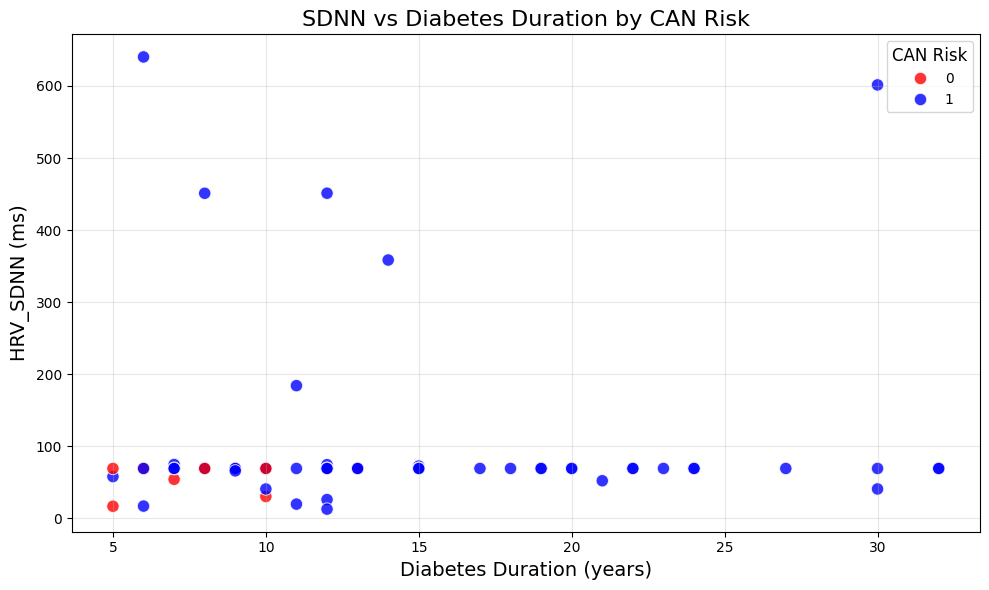

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

# Define custom colors for the two classes
custom_palette = {0: 'red', 1: 'blue'}

sns.scatterplot(
    data=df_full, 
    x='diabetes_duration', 
    y='HRV_SDNN', 
    hue='CAN_risk_label', 
    palette=custom_palette,
    s=80,         # marker size
    alpha=0.8     # transparency
)

plt.title('SDNN vs Diabetes Duration by CAN Risk', fontsize=16)
plt.xlabel('Diabetes Duration (years)', fontsize=14)
plt.ylabel('HRV_SDNN (ms)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='CAN Risk', title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()


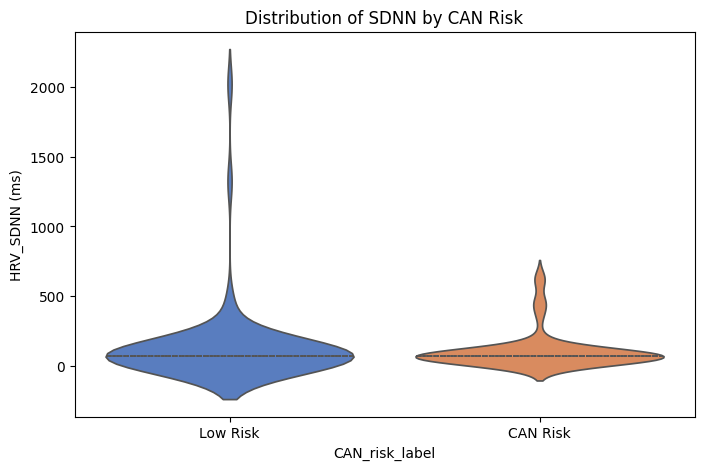

In [59]:
plt.figure(figsize=(8,5))
sns.violinplot(x='CAN_risk_label', y='HRV_SDNN', data=df_full, palette="muted", inner='quartile')
plt.xticks([0,1], ['Low Risk', 'CAN Risk'])
plt.title("Distribution of SDNN by CAN Risk")
plt.ylabel("HRV_SDNN (ms)")
plt.show()


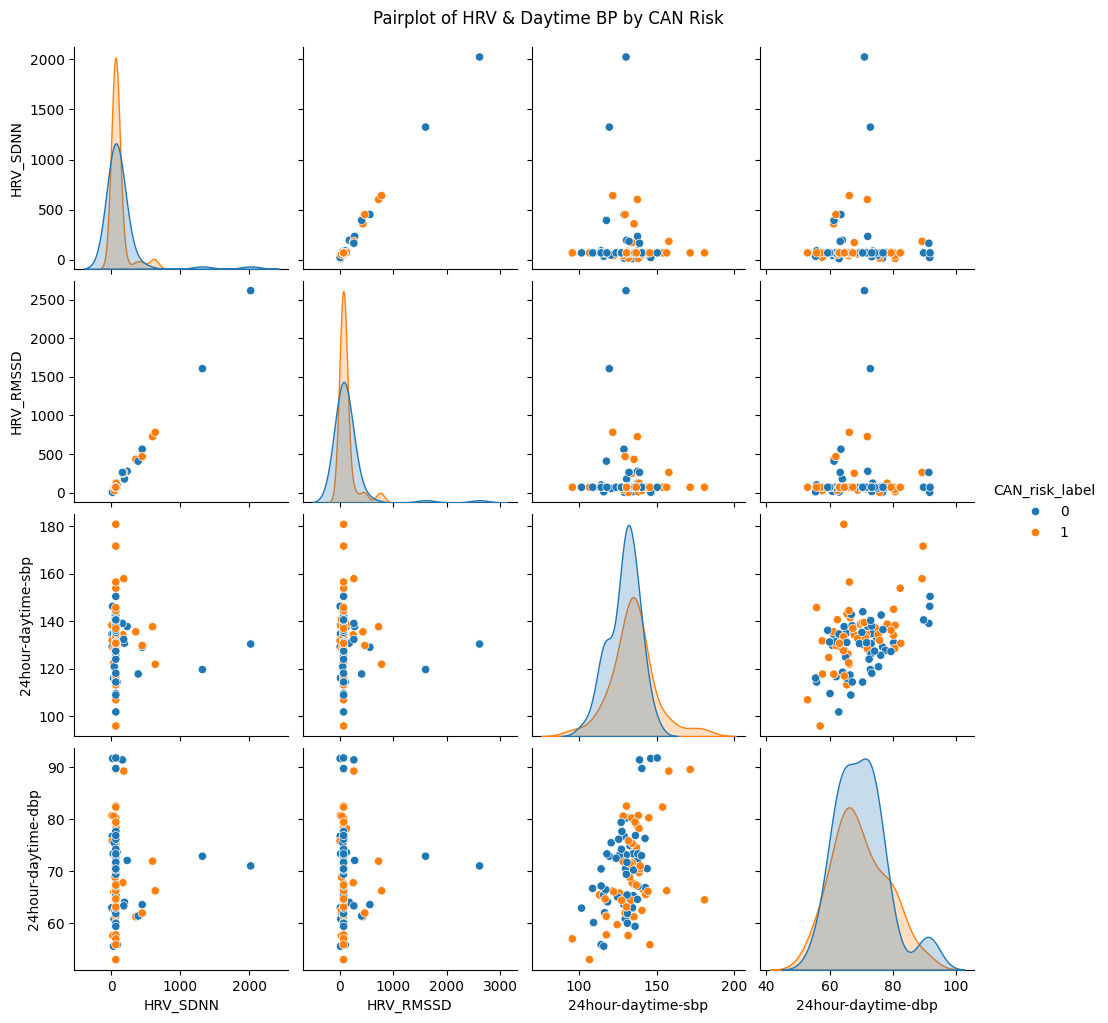

In [60]:
sns.pairplot(df_full[['HRV_SDNN', 'HRV_RMSSD', '24hour-daytime-sbp', '24hour-daytime-dbp', 'CAN_risk_label']].dropna(), 
             hue='CAN_risk_label', diag_kind='kde')
plt.suptitle("Pairplot of HRV & Daytime BP by CAN Risk", y=1.02)
plt.show()


#########

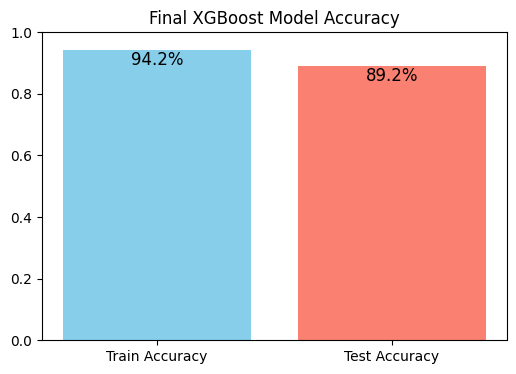

In [91]:
import matplotlib.pyplot as plt

train_acc = 0.94234  # 94%
test_acc = 0.8920   # 89%

plt.figure(figsize=(6,4))
bars = plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'salmon'])
plt.ylim(0,1)
plt.title('Final XGBoost Model Accuracy')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.05, f'{height*100:.1f}%', ha='center', color='black', fontsize=12)
plt.show()


Number of selected features: 257
Length of importances: 257


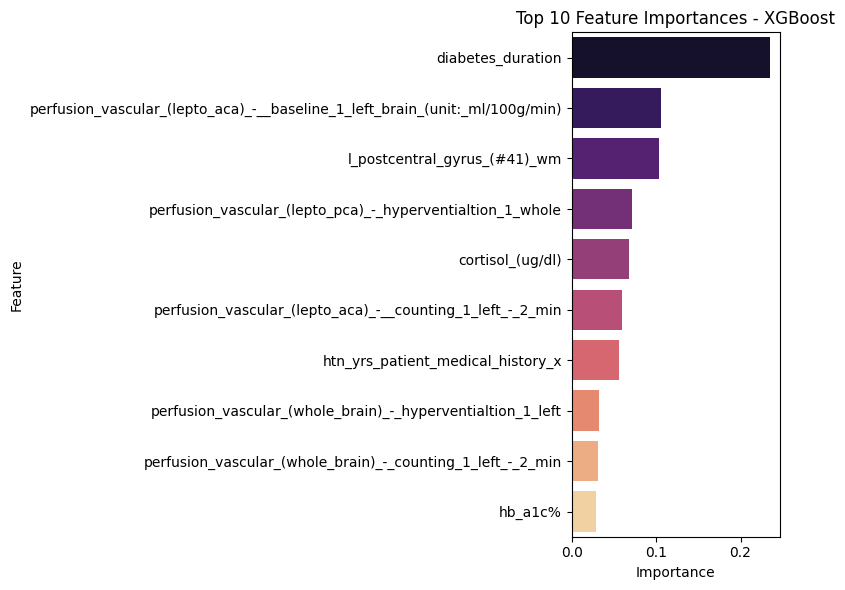

In [75]:
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]

# Get importances from the final model trained on selected features
importances = best_model.feature_importances_



print(f"Number of selected features: {len(selected_features)}")
print(f"Length of importances: {len(importances)}")

assert len(selected_features) == len(importances), "Mismatch in feature and importance lengths"

feat_imp_df = pd.DataFrame({
    'feature': selected_features,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='magma')
plt.title('Top 10 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


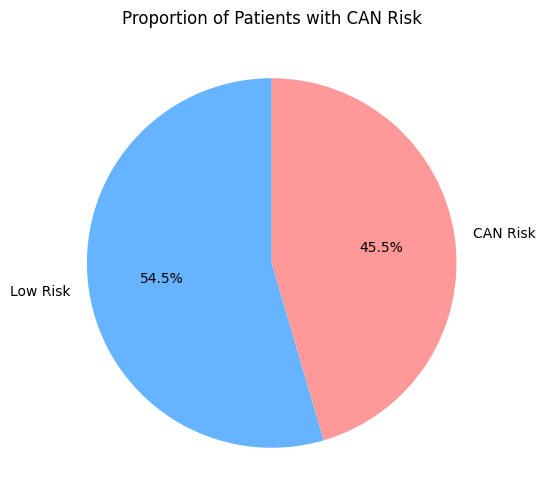

In [63]:
# Pie chart for CAN Risk
risk_counts = df_full['CAN_risk_label'].value_counts().reindex([0,1], fill_value=0)

plt.figure(figsize=(6,6))
plt.pie(risk_counts, labels=["Low Risk", "CAN Risk"], autopct='%1.1f%%', colors=["#66b3ff", "#ff9999"], startangle=90)
plt.title("Proportion of Patients with CAN Risk")
plt.show()


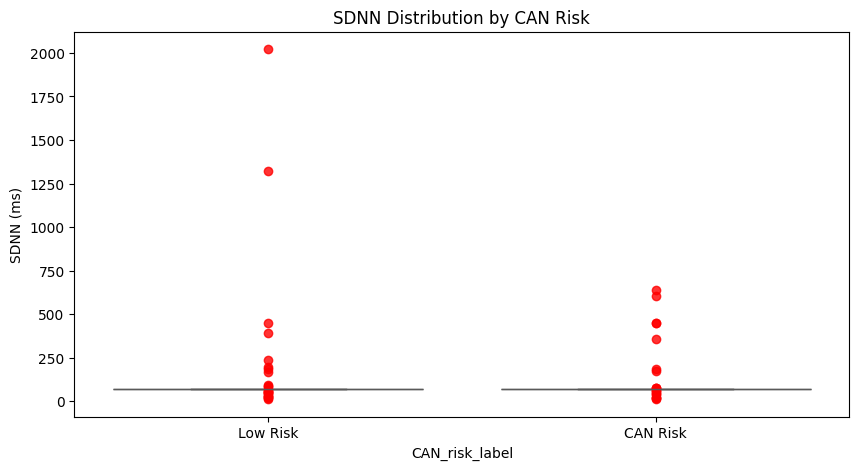

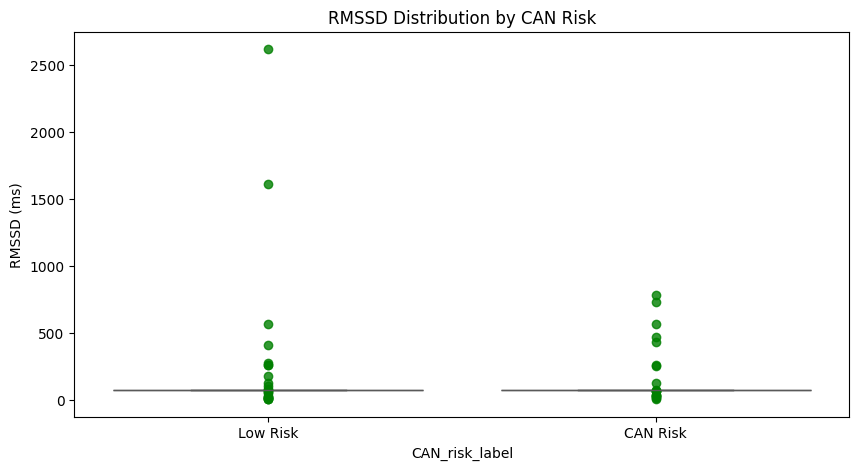

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define properties for outliers (fliers)
flierprops = dict(marker='o', markerfacecolor='red', markeredgecolor='red', markersize=6, alpha=0.8)

plt.figure(figsize=(10,5))
sns.boxplot(
    x='CAN_risk_label', 
    y='HRV_SDNN', 
    data=df_full, 
    palette="Set2",
    flierprops=flierprops
)
plt.xticks([0,1], ['Low Risk', 'CAN Risk'])
plt.title("SDNN Distribution by CAN Risk")
plt.ylabel("SDNN (ms)")
plt.show()

flierprops = dict(marker='o', markerfacecolor='green', markeredgecolor='green', markersize=6, alpha=0.8)

plt.figure(figsize=(10,5))
sns.boxplot(
    x='CAN_risk_label', 
    y='HRV_RMSSD', 
    data=df_full, 
    palette="Set2",
    flierprops=flierprops
)
plt.xticks([0,1], ['Low Risk', 'CAN Risk'])
plt.title("RMSSD Distribution by CAN Risk")
plt.ylabel("RMSSD (ms)")
plt.show()


In [65]:
df_plot = df_full.copy()
df_plot['CAN Risk'] = df_plot['CAN_risk_label'].map({0: 'Low Risk', 1: 'CAN Risk'})

# Select columns to plot - choose only columns that exist
cols_to_plot = ['HRV_SDNN', 'HRV_RMSSD']

# Add LF/HF ratio if exists
if 'HRV_LF_HF_ratio' in df_plot.columns:
    cols_to_plot.append('HRV_LF_HF_ratio')

cols_to_plot.append('CAN Risk')  # target for hue

print("Plotting HRV features:", cols_to_plot)


Plotting HRV features: ['HRV_SDNN', 'HRV_RMSSD', 'CAN Risk']


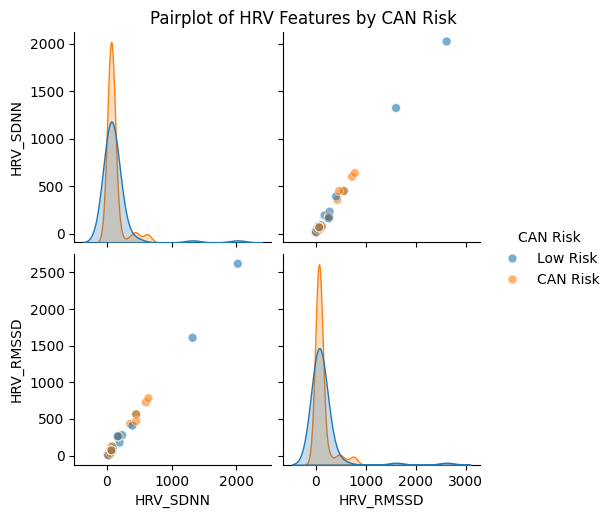

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df_plot[cols_to_plot], hue='CAN Risk', diag_kind='kde', plot_kws={'alpha':0.6, 's':40})
plt.suptitle("Pairplot of HRV Features by CAN Risk", y=1.02)
plt.show()


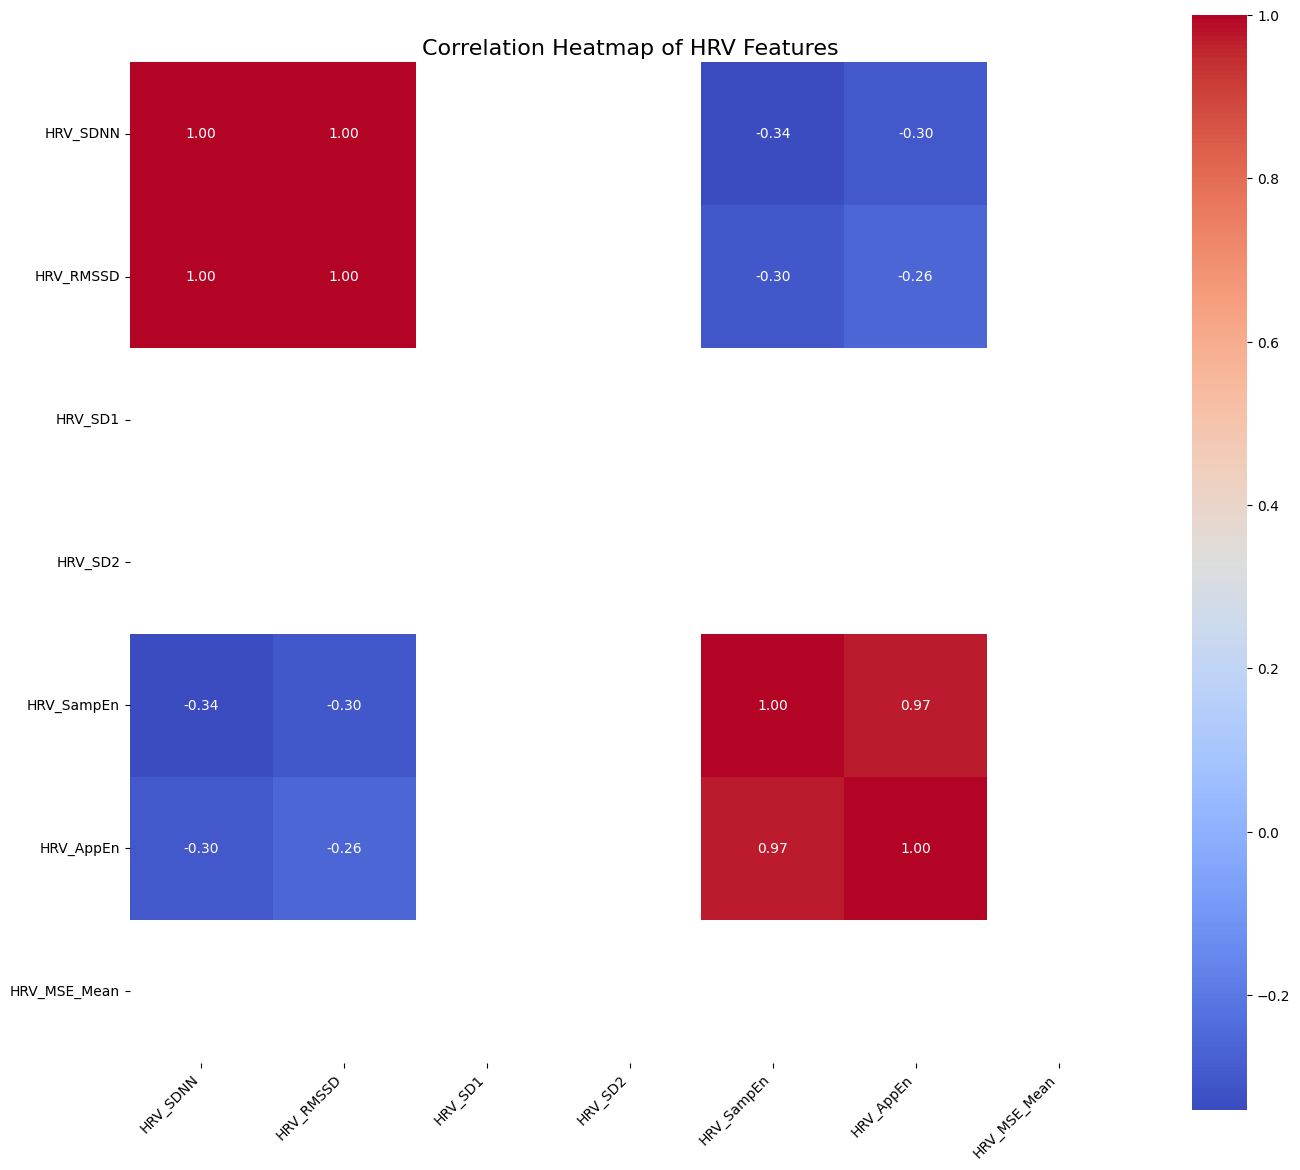

In [67]:
# Define HRV columns
hrv_cols_existing = [col for col in df_full.columns if col.startswith('HRV_')]

# Then plot correlation heatmap
plt.figure(figsize=(14,12))
sns.heatmap(df_full[hrv_cols_existing].corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of HRV Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


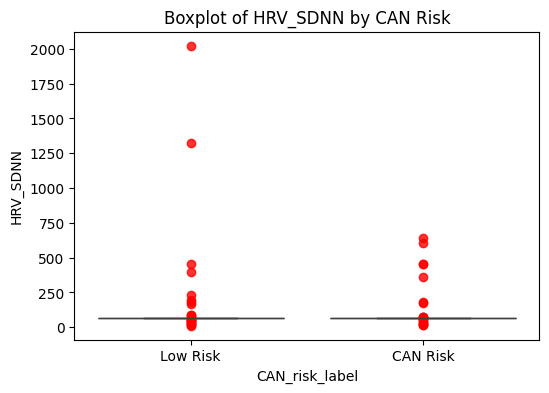

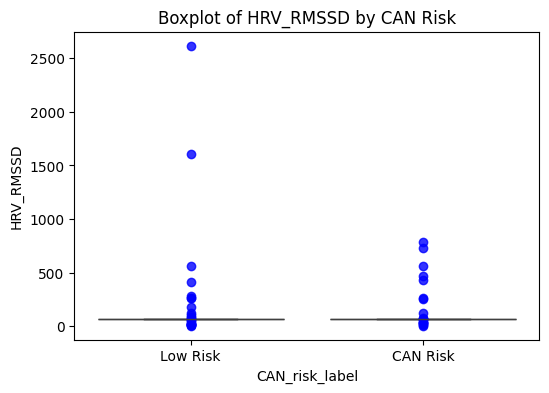

In [68]:
key_hrv_feats = ['HRV_SDNN', 'HRV_RMSSD']

# Define outlier colors for each feature
outlier_colors = {
    'HRV_SDNN': 'red',
    'HRV_RMSSD': 'blue'
}

for feat in key_hrv_feats:
    flierprops = dict(marker='o',
                      markerfacecolor=outlier_colors[feat],
                      markeredgecolor=outlier_colors[feat],
                      markersize=6,
                      alpha=0.8)
    
    plt.figure(figsize=(6,4))
    sns.boxplot(x='CAN_risk_label', y=feat, data=df_full, flierprops=flierprops)
    plt.xticks([0,1], ['Low Risk', 'CAN Risk'])
    plt.title(f"Boxplot of {feat} by CAN Risk")
    plt.show()


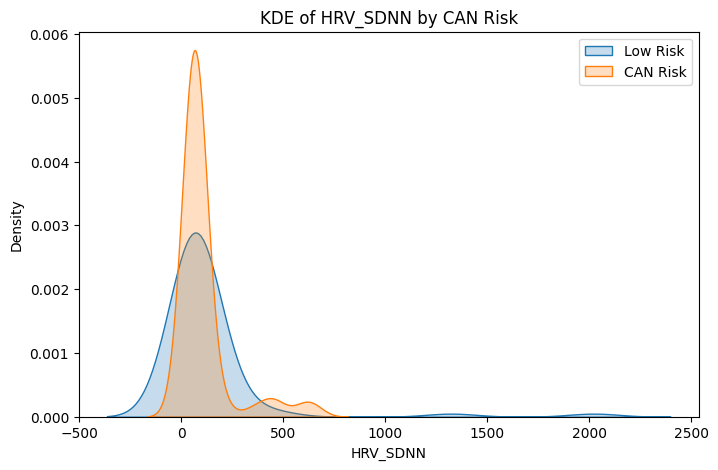

In [69]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_full.loc[df_full['CAN_risk_label']==0, 'HRV_SDNN'], label='Low Risk', shade=True)
sns.kdeplot(df_full.loc[df_full['CAN_risk_label']==1, 'HRV_SDNN'], label='CAN Risk', shade=True)
plt.title("KDE of HRV_SDNN by CAN Risk")
plt.xlabel('HRV_SDNN')
plt.legend()
plt.show()


In [70]:
print(cv_results_df['XGBoost'])


NameError: name 'cv_results_df' is not defined

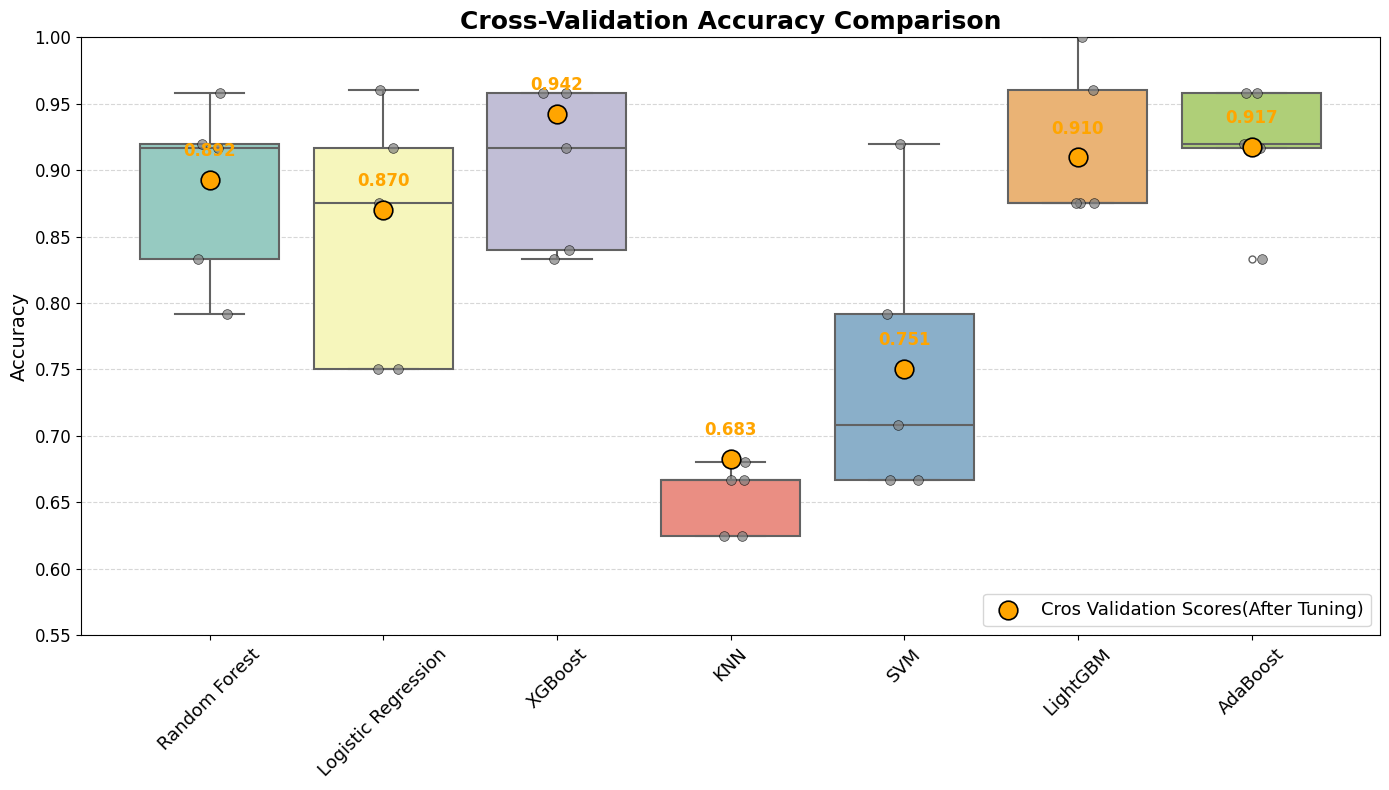

In [71]:
# Your CV results DataFrame (fold accuracies per model)
cv_results_df = pd.DataFrame({k: v for k, v in results.items()})

# Final mean scores after tuning
after_best_scores_full = {
    'Random Forest': 0.8923,
    'Logistic Regression': 0.8703,
    'XGBoost': 0.9423,
    'KNN': 0.6827,
    'SVM': 0.7507,
    'LightGBM': 0.9096,
    'AdaBoost': 0.9175
}

plt.figure(figsize=(14,8))

# Boxplot for CV accuracies before tuning
sns.boxplot(data=cv_results_df, 
            palette="Set3",  # softer pastel palette
            linewidth=1.5,   # thicker lines
            fliersize=5)     # size of outlier points

# Overlay jittered points of CV fold scores for detail
sns.stripplot(data=cv_results_df, 
              color='gray', 
              size=7, 
              jitter=True, 
              alpha=0.7, 
              edgecolor='black', 
              linewidth=0.5)

models = list(after_best_scores_full.keys())
mean_scores = [after_best_scores_full[m] for m in models]

# Plot big orange dots for tuned mean scores
for i, (model, score) in enumerate(zip(models, mean_scores)):
    plt.scatter(i, score, 
                color='orange', 
                s=180, 
                zorder=10, 
                edgecolor='black', 
                linewidth=1.2, 
                label='Cros Validation Scores(After Tuning)' if i == 0 else "")

# Add numeric labels above tuned scores
for i, score in enumerate(mean_scores):
    plt.text(i, score + 0.015, f"{score:.3f}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='orange')

plt.title("Cross-Validation Accuracy Comparison", fontsize=18, fontweight='bold')
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0.55, 1.0)

plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right', fontsize=13)

plt.tight_layout()
plt.show()

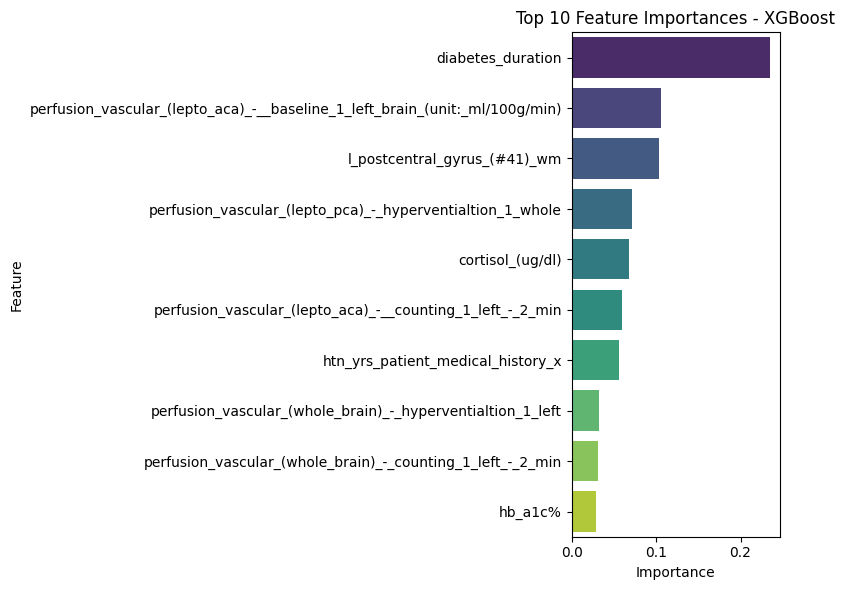

In [74]:
importances = best_model.feature_importances_

# Get correct feature names if X_selected is a NumPy array
feat_names = X.columns[selected_mask]  # Use your actual mask variable here

feat_imp_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
